# Long Short Term Memory Network (LSTM)

## Load Libraries and Dataset

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as K
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from keras.models import load_model
import re

In [11]:
db = sqlite3.connect('D:\dsc_platinum\database.db', check_same_thread = False)
q_data = 'SELECT * FROM data'
data = pd.read_sql_query(q_data, db)
data.head()

Tweet     Label
0  warung ini dimiliki oleh pengusaha pabrik tahu...  positive
1  mohon ulama lurus dan k mmbri hujjah partai ap...   neutral
2  lokasi strategis di jalan sumatra bandung temp...  positive
3  betapa bahagia nya diri ini saat unboxing pake...  positive
4  aduh jadi mahasiswa jangan sombong dong kasih ...  negative

In [12]:
data['Label'].value_counts()

positive    6383
negative    3412
neutral     1138
Name: Label, dtype: int64

## Feature-Label Classification

In [13]:
data_pos = data[data['Label']=='positive']
data_neu = data[data['Label']=='neutral']
data_neg = data[data['Label']=='negative']

df_neu = data_neu.sample(data_neg.shape[0], replace = True)

data = pd.concat([data_pos, df_neu, data_neg])

pos_tweet = data.loc[data['Label']=='positive'].Tweet.tolist()
neg_tweet = data.loc[data['Label']=='negative'].Tweet.tolist()
neu_tweet = data.loc[data['Label']=='neutral'].Tweet.tolist()

pos_label = data.loc[data['Label']=='positive'].Label.tolist()
neg_label = data.loc[data['Label']=='negative'].Label.tolist()
neu_label = data.loc[data['Label']=='neutral'].Label.tolist()

In [14]:
total_data = pos_tweet + neg_tweet + neu_tweet
labels = pos_label + neu_label + neg_label

print("Kata Positif: %s" % len(pos_tweet))
print("Total Negatif: %s" % len(neu_tweet))
print("Total Neutral: %s" % len(neg_tweet))
print("Total Data: %s" % len(total_data))

Kata Positif: 6383
Total Negatif: 3412
Total Neutral: 3412
Total Data: 13207


## Feature Extraction

In [15]:
# Tokenizer

max_features = 100000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenizer.fit_on_texts(total_data)
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("tokenizer.pickle berhasil dibuat!")
    
# pad sequence
X = tokenizer.texts_to_sequences(total_data)

vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)

X = pad_sequences(X)
with open('x_pad_sequences.pickle', 'wb') as handle:
    pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("x_pad_sequences.pickle berhasil dibuat!")

tokenizer.pickle berhasil dibuat!
x_pad_sequences.pickle berhasil dibuat!


In [16]:
Y = pd.get_dummies(labels)
Y = Y.values

with open('y_labels.pickle', 'wb') as handle:
    pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("y_labels.pickle berhasil dibuat!")

y_labels.pickle berhasil dibuat!


## Train-Test Data Split

In [17]:
file = open("x_pad_sequences.pickle",'rb')
X = pickle.load(file)
file.close()

file = open("y_labels.pickle",'rb')
Y = pickle.load(file)
file.close()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## Model Training

In [18]:
kf = KFold(n_splits=5,random_state=42,shuffle=True)

accuracies = []

y = Y

embed_dim = 100
units = 64

for iteration, data in enumerate(kf.split(X), start=1):

    data_train   = X[data[0]]
    target_train = y[data[0]]

    data_test    = X[data[1]]
    target_test  = y[data[1]]
    

    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
    model.add(LSTM(units, dropout=0.5))
    model.add(Dense(3,activation='softmax'))
    

    adam = optimizers.Adam(learning_rate = 0.0005)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
    history = model.fit(data_train, target_train, epochs=50, batch_size=32, 
                        validation_data=(data_test, target_test), verbose=1, callbacks=[es])

    predictions = model.predict(X_test)
    y_pred = predictions


    
    accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))

    print("Proses Training ke-", iteration)
    print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
    print("======================================================")

    accuracies.append(accuracy)

average_accuracy = np.mean(accuracies)

print()
print()
print()
print("Rata-rata Akurasi: ", round(average_accuracy,4))

Epoch 1/50
331/331 [==============================] - 59s 171ms/step - loss: 0.6299 - accuracy: 0.7358 - val_loss: 0.3479 - val_accuracy: 0.8698
Epoch 2/50
331/331 [==============================] - 48s 146ms/step - loss: 0.2787 - accuracy: 0.9002 - val_loss: 0.2625 - val_accuracy: 0.9039
Epoch 3/50
331/331 [==============================] - 51s 154ms/step - loss: 0.1726 - accuracy: 0.9422 - val_loss: 0.2497 - val_accuracy: 0.9118
Epoch 4/50
331/331 [==============================] - 51s 153ms/step - loss: 0.1288 - accuracy: 0.9570 - val_loss: 0.2250 - val_accuracy: 0.9167
Epoch 5/50
331/331 [==============================] - 51s 153ms/step - loss: 0.0894 - accuracy: 0.9699 - val_loss: 0.2295 - val_accuracy: 0.9182
Epoch 6/50
331/331 [==============================] - 56s 170ms/step - loss: 0.0708 - accuracy: 0.9754 - val_loss: 0.2493 - val_accuracy: 0.9156
Epoch 6: early stopping
83/83 [==============================] - 2s 17ms/step
Proses Training ke- 1
              precision    rec

## Evaluation

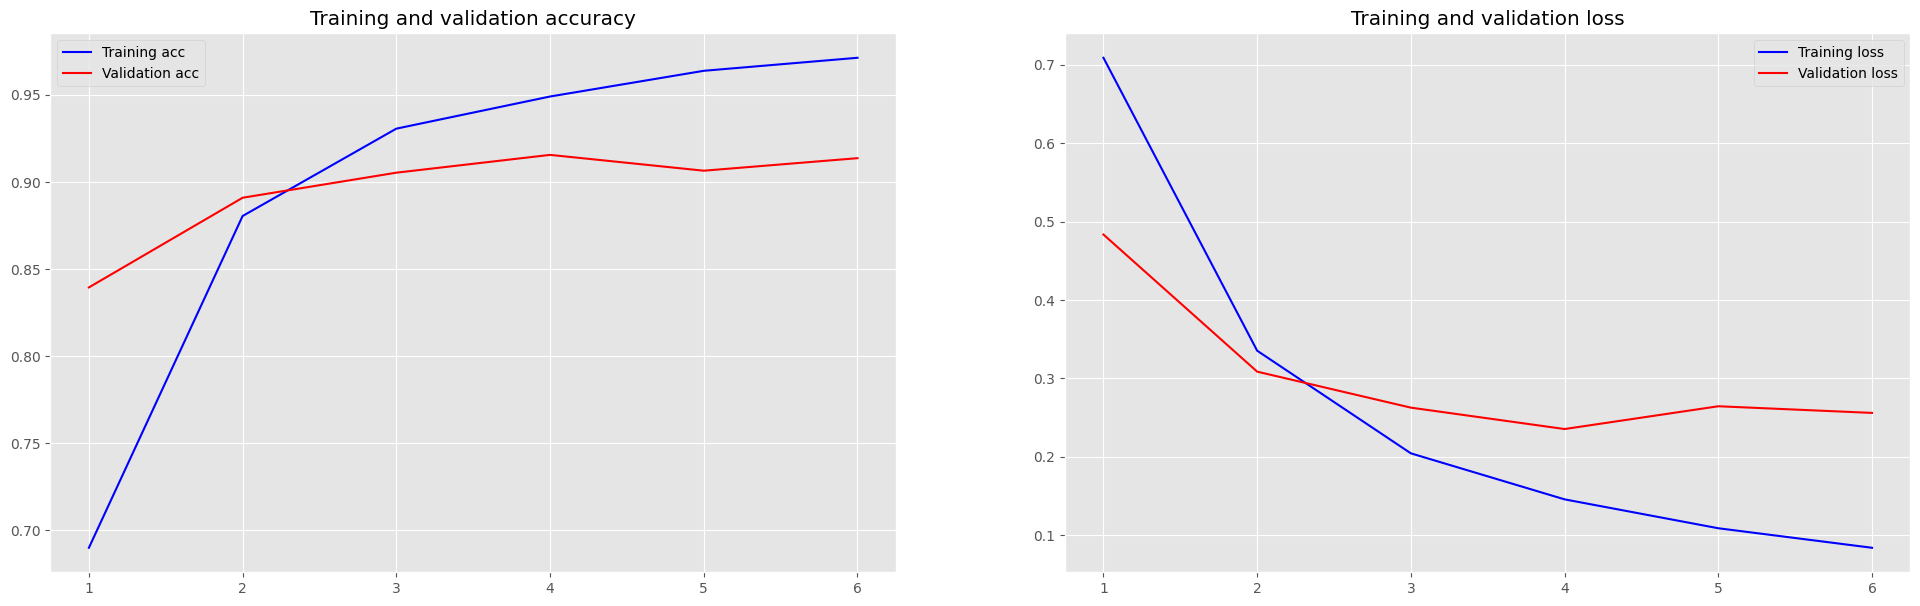

In [19]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(24, 7))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

%matplotlib inline
plot_history(history)

In [20]:
# Save the model

model.save('model.h5')
print("Model Berhasil dibuat!")

Model Berhasil dibuat!


## Prediction

In [21]:
input_text = """
Makanannya enak  """

def cleansing(sent):
    string = sent.lower()
    string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
    return string

sentiment = ['negative', 'neutral', 'positive']

text = [cleansing(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])
hasil = sentiment[polarity]

print("Contoh Text: %s" % text[0])
print("Sentiment: %s" % sentiment[polarity])

1/1 [==============================] - 0s 382ms/step
Contoh Text:  makanannya enak  
Sentiment: positive


In [22]:
input_text = """
Normal saja  """

def cleansing(sent):
    string = sent.lower()
    string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
    return string

sentiment = ['negative', 'neutral', 'positive']

text = [cleansing(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])
hasil = sentiment[polarity]

print("Contoh Text: %s" % text[0])
print("Sentiment: %s" % sentiment[polarity])

1/1 [==============================] - 0s 381ms/step
Contoh Text:  normal saja  
Sentiment: neutral
